# CLASSIFICATION OF LAB SAMPLES

This notebook analyzes the AM_MDM and AW_plus_v_AW_neg samples.

# Preliminaries

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common import transform_data

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

%matplotlib inline

# Data
Data used in the analysis.

In [2]:
DATA = TrinaryData()
DATA.df_X.head()

,Rv1927,Rv1129c,Rv3085,Rv3083,Rv3086,Rv2226,Rv0260c,Rv1365c,Rv3084,Rv0975c,...,Rv3267,Rv2748c,Rv3260c,Rv0350,Rv2737c,Rv0440--Rv3417c,Rv2734,Rv0519c,Rv3418c,Rv3269
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [3]:
# Not averaged
DATA = TrinaryData(is_regulator=True, is_averaged=True, is_dropT1=True)
DATA.df_X.head()

,Rv0047c,Rv3249c,Rv0232,Rv3855,Rv0474,Rv1189,Rv0022c,Rv3167c,Rv1675c,Rv2250c,...,Rv1657,Rv3133c,Rv0054,Rv1994c,Rv3597c,Rv3414c,Rv3246c,Rv0353,Rv3260c,Rv3417c
T2,-1,0,0,0,0,-1,-1,-1,-1,-1,...,0,0,0,1,1,1,1,1,1,1
T3,-1,-1,0,0,0,-1,-1,-1,-1,-1,...,0,0,0,1,1,1,1,1,1,1
T4,-1,0,-1,0,0,-1,-1,-1,-1,-1,...,0,0,1,0,1,1,1,1,1,1
T5,0,0,0,0,0,-1,-1,-1,-1,-1,...,0,1,1,1,1,1,1,0,1,1
T6,0,0,0,0,0,-1,-1,-1,-1,-1,...,0,1,1,0,1,1,1,0,1,1


In [4]:
DATA.ser_y.head()

timepoint
T2    1
T3    1
T4    1
T5    1
T6    1
Name: name, dtype: int64

In [5]:
df_sampleAM = transform_data.trinaryReadsDF(
    csv_file="AM_MDM_Mtb_transcripts_DEseq.csv", is_time_columns=False, is_display_errors=False)
df_sampleAW = transform_data.trinaryReadsDF(csv_file="AW_plus_v_AW_neg_Mtb_transcripts_DEseq.csv",
                                            is_time_columns=False, is_display_errors=False)

In [6]:
df_sampleAM = df_sampleAM.T
df_sampleAW.columns

Index(['AW_plus_1', 'AW_neg_1', 'AW_plus_3', 'AW_neg_3', 'AW_plus_4',
       'AW_neg_4'],
      dtype='object')

In [7]:
df_sampleAW = df_sampleAW.T
df_sampleAW.head()

GENE_ID,Rv0001,Rv0005,Rv0006,Rv0009,Rv0010c,Rv0011c,Rv0013,Rv0014c,Rv0016c,Rv0020c,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
AW_plus_1,0,0,0,0,-1,0,-1,0,0,0,...,0,0,-1,0,-1,0,-1,0,0,-1
AW_neg_1,1,1,0,0,-1,1,-1,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AW_plus_3,0,0,0,0,-1,1,0,0,0,0,...,0,0,-1,0,-1,-1,-1,-1,-1,-1
AW_neg_3,1,0,0,0,-1,1,0,0,0,0,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
AW_plus_4,0,0,0,0,-1,1,0,0,0,0,...,0,0,-1,-1,-1,-1,-1,-1,-1,1


# Classification Validations of Controlled Samples
Classify T2-T25 and see if result is same as original class. Use 5-fold cross validation, where there is a holdout for each class and the selection is random.


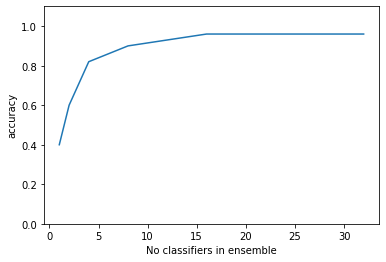

In [8]:
accuracy_dct = {}
for rank in [1, 2, 4, 8, 16, 32]:
    accuracy_dct[rank] = classifier_ensemble.ClassifierEnsemble.crossValidate(
        DATA, num_iter=10, num_holdout=1, filter_high_rank=rank)
plt.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()))
plt.ylim([0, 1.1])
_ = plt.xlabel("No classifiers in ensemble")
_ = plt.ylabel("accuracy")

In [14]:
DATA.ser_y

timepoint
T2     1
T3     1
T4     1
T5     1
T6     1
T7     1
T8     2
T9     2
T10    3
T11    2
T12    3
T13    3
T14    3
T15    3
T16    4
T17    4
T18    4
T19    2
T20    2
T21    2
T22    0
T23    0
T24    0
T25    0
Name: name, dtype: int64

# Classification of Lab Samples

In [10]:
svm_ensemble = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=15, size=30)
df_X = DATA.df_X.copy()
df_X.columns = DATA.features
svm_ensemble.fit(df_X, DATA.ser_y)

In [11]:
svm_ensemble.predict(df_sampleAM)

,0,1,2,3,4
AM_D20_1,0.0,0.000000,0.0,1.000000,0.000000
AM_D20_3,0.0,0.000000,0.0,1.000000,0.000000
AM_D20_4,0.0,0.000000,0.0,0.933333,0.066667
AM_D20_5,0.0,0.000000,0.0,1.000000,0.000000
MDM_D20_1,0.0,0.066667,0.0,0.933333,0.000000
MDM_D20_3,0.0,0.000000,0.0,1.000000,0.000000
MDM_D20_4,0.0,1.000000,0.0,0.000000,0.000000
MDM_D20_5,0.0,0.000000,0.0,1.000000,0.000000


In [12]:
svm_ensemble.predict(df_sampleAW)

,0,1,2,3,4
AW_plus_1,0.0,1.0,0.0,0.0,0.0
AW_neg_1,0.0,0.0,0.0,1.0,0.0
AW_plus_3,0.0,0.0,0.0,1.0,0.0
AW_neg_3,0.0,0.0,0.0,1.0,0.0
AW_plus_4,0.0,0.0,0.0,0.0,1.0
AW_neg_4,0.0,0.0,0.0,1.0,0.0


# Support for Prediction